In [ ]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]


class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

      
        self.lin_1 = nn.Linear(24, 100)
        self.lin_2 = nn.Linear(100, 24)
        self.bn = nn.BatchNorm1d(100)
        #self.lin_3 = nn.Linear(48, 24)
        
        
        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        #self.act_3 = nn.ReLU()

    def forward(self, x):
        
        pred = self.lin_1(x)
        pred = self.act_1(pred)
        pred = self.bn(pred)
        pred = self.lin_2(pred)
        pred = self.act_2(pred)
        
        
        #pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        pred = torch.min(pred, x)
        return pred


class AppliancesRNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesRNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomRNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomRNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        # print("Subtracting prediction")
        else:
            pass
        # print("Subtracting true")
        for appliance in range(self.num_appliance):
            # print(agg_current.mean().data[0])
            # print appliance
            # print self.order[appliance]
            # print args[2+appliance]
            #print(getattr(self, "Appliance_" + str(appliance)))
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

#ORDER = APPLIANCE_ORDER[1:][::-1]


lr = 0.5
p = 0.1
num_folds = 5
fold_num = 0

torch.manual_seed(0)

In [29]:
preds = []
gts = []
for fold_num in range(5):
    train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)
    train_aggregate = train[:, 0, :, :].reshape(-1, 24)
    test_aggregate = test[:, 0, :, :].reshape(-1, 24)
    ORDER = APPLIANCE_ORDER[1:][:][::-1]
    out_train = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_train[a_num] = Variable(
            torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train_aggregate.shape[0], -1))))
        if cuda_av:
            out_train[a_num] = out_train[a_num].cuda()

    out_test = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_test[a_num] = Variable(
            torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test_aggregate.shape[0], -1))))
        if cuda_av:
            out_test[a_num] = out_test[a_num].cuda()

    loss_func = nn.L1Loss()
    a = AppliancesRNN(num_appliance=len(ORDER))
    #for param in a.parameters():
    #    param.data = param.data.abs()
    #print(a)
    if cuda_av:
        a = a.cuda()
        loss_func = loss_func.cuda()
    optimizer = torch.optim.Adam(a.parameters(), lr=lr)
    inp = Variable(torch.Tensor(train_aggregate.reshape((train_aggregate.shape[0], -1))).type(torch.FloatTensor),
               requires_grad=True)
    for t in range(100):
        inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)
        out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
        ot =  torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
        if cuda_av:
            inp = inp.cuda()
            out = out.cuda()
            ot = ot.cuda()

        params = [inp, p]
        for a_num, appliance in enumerate(ORDER):
            params.append(out_train[a_num])
        # print(params)
        pred = a(*params)

        optimizer.zero_grad()
        pred_split = torch.split(pred, pred.size(0)//len(ORDER))

        losses= [loss_func(pred_split[appliance_num], out_train[appliance_num])*weight_appliance[appliance] for appliance_num, appliance in enumerate(ORDER)]

        loss = sum(losses)
        if t % 1 == 0:
            print(t, loss.data[0])

        loss.backward()
        optimizer.step()
    
    test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
    if cuda_av:
        test_inp = test_inp.cuda()

    params = [test_inp, -2]
    for i in range(len(ORDER)):
        params.append(None)
    pr = a(*params)
    pr = torch.clamp(pr, min=0.)
    test_pred = torch.split(pr, test_aggregate.shape[0])
    prediction_fold = [None for x in range(len(ORDER))]

    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
    gt_fold = [None for x in range(len(ORDER))]
    for appliance_num, appliance in enumerate(ORDER):
        gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                             1).reshape(-1, 24)
    
    preds.append(prediction_fold)
    gts.append(gt_fold)

0 1076.11181640625
1 1070.938720703125
2 1028.187255859375
3 977.5824584960938
4 929.2132568359375
5 830.7522583007812
6 709.0125122070312
7 604.77099609375
8 489.283935546875
9 380.3502197265625
10 305.5159912109375
11 257.2585144042969
12 145.20889282226562
13 236.28952026367188
14 128.23452758789062
15 238.1992645263672
16 237.1199951171875
17 240.79830932617188
18 241.17874145507812
19 238.61563110351562
20 124.09994506835938
21 242.2742462158203
22 238.86517333984375
23 237.9345703125
24 239.68179321289062
25 237.87062072753906
26 236.08758544921875
27 123.59862518310547
28 238.76730346679688
29 235.51092529296875
30 234.92056274414062
31 235.71185302734375
32 124.13011932373047
33 233.33518981933594
34 233.79013061523438
35 232.1378936767578
36 231.04302978515625
37 231.27284240722656
38 230.36221313476562
39 229.02090454101562
40 228.6669921875
41 227.31040954589844
42 121.26946258544922
43 225.91494750976562
44 120.4115982055664
45 223.81005859375
46 222.67343139648438
47 221.4

85 110.77985382080078
86 198.8011932373047
87 198.2984619140625
88 198.2664031982422
89 197.6966094970703
90 197.38540649414062
91 196.89913940429688
92 196.7741241455078
93 196.2899627685547
94 195.9985809326172
95 195.41868591308594
96 195.21168518066406
97 194.805419921875
98 194.6692352294922
99 109.92664337158203
0 1065.078857421875
1 1059.01025390625
2 1017.2645874023438
3 970.4786987304688
4 911.766357421875
5 813.132568359375
6 691.46923828125
7 583.2713623046875
8 467.8120422363281
9 363.2965393066406
10 290.95855712890625
11 243.24673461914062
12 226.14291381835938
13 226.72576904296875
14 225.91259765625
15 226.49887084960938
16 230.88632202148438
17 230.5638885498047
18 228.6019287109375
19 230.08111572265625
20 229.52589416503906
21 119.36282348632812
22 229.22640991210938
23 228.9317626953125
24 227.8916015625
25 227.72235107421875
26 227.2603759765625
27 226.84793090820312
28 226.88136291503906
29 226.40945434570312
30 225.80908203125
31 225.838623046875
32 225.351654052

In [30]:
prediction_flatten = {}
gt_flatten = {}
for appliance_num, appliance in enumerate(ORDER):
    prediction_flatten[appliance] = []
    gt_flatten[appliance] = []

for appliance_num, appliance in enumerate(ORDER):
    for fold in range(5):
        prediction_flatten[appliance].append(preds[fold][appliance_num])
        gt_flatten[appliance].append(gts[fold][appliance_num])
    gt_flatten[appliance] = np.concatenate(gt_flatten[appliance])
    prediction_flatten[appliance] = np.concatenate(prediction_flatten[appliance])

In [31]:
err = {}
for appliance in ORDER:
    print(appliance)
    err[appliance] = mean_absolute_error(gt_flatten[appliance], prediction_flatten[appliance])
    

mw
dw
dr
fridge
hvac


In [32]:
err

{'dr': 65.005419138642807,
 'dw': 15.458415267896692,
 'fridge': 28.706636344860328,
 'hvac': 101.01263027599866,
 'mw': 9.1237160878272707}

In [33]:
ORDER

['mw', 'dw', 'dr', 'fridge', 'hvac']

In [426]:
inp.size()

torch.Size([6048, 24])

0 1076.11181640625
1 1070.938720703125
2 1025.09716796875
3 977.877197265625
4 929.3828125
5 830.4874267578125
6 694.1065673828125
7 606.2401123046875
8 451.72186279296875
9 384.78033447265625
10 307.5211181640625
11 185.30514526367188
12 148.3186798095703
13 237.27493286132812
14 237.000244140625
15 236.34933471679688
16 238.7250213623047
17 241.39376831054688
18 240.4036865234375
19 238.69004821777344
20 238.80625915527344
21 123.43766021728516
22 238.75164794921875
23 238.42416381835938
24 237.37493896484375
25 236.23265075683594
26 235.77267456054688
27 235.67715454101562
28 235.05369567871094
29 234.29226684570312
30 233.63815307617188
31 122.84083557128906
32 233.67941284179688
33 232.93856811523438
34 232.65924072265625
35 232.101318359375
36 231.8216552734375
37 231.63238525390625
38 231.34359741210938
39 231.1046142578125
40 230.455322265625
41 230.53903198242188
42 122.7012939453125
43 229.8604736328125
44 122.0085220336914
45 229.78407287597656
46 228.8340606689453
47 228.67

In [429]:
params = list(a.parameters())

In [430]:
params

[Parameter containing:
 -1.5995 -1.5240 -2.6355  ...  -1.9197 -1.8259 -2.1846
  3.6323  3.5661  3.9841  ...   3.3299  3.6711  3.7424
  3.3736  3.6348  3.6204  ...   2.9308  3.0502  3.0158
           ...             ⋱             ...          
 -3.2108 -3.2985 -3.2361  ...  -3.1401 -3.0643 -3.0597
  2.4796  3.0375  2.6242  ...  -4.6559 -2.3769  0.3505
 -0.1601 -0.1584 -0.3847  ...   1.0365  1.0106  0.6948
 [torch.FloatTensor of size 100x24], Parameter containing:
  0.8151
 -2.0231
 -3.8692
 -0.0533
  1.6422
 -0.7229
  2.9613
  1.5639
  1.5278
  1.8315
 -0.0357
  2.0795
  2.2423
 -2.5087
  2.3259
  1.7966
 -0.0218
  1.6275
  0.2338
 -0.6721
  2.3597
 -2.1550
  1.2220
  2.0568
  0.1024
 -2.4473
  1.6953
 -0.2741
  0.9372
 -0.9709
 -1.8368
  0.7394
  0.7807
 -1.3831
 -2.6330
  0.5271
  0.1156
 -1.3261
  1.8088
  0.2481
  1.3162
 -2.0229
  0.0986
  1.9043
 -1.4472
 -0.2870
  0.4587
 -0.6539
  0.1858
 -1.4155
  1.7647
 -0.3786
 -0.9140
  0.7600
 -0.1318
 -2.9859
 -2.9456
  0.7283
  1.6349
 -

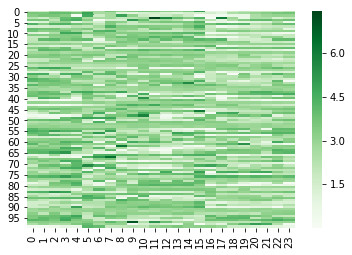

In [431]:
import seaborn as sns
sns.heatmap(np.abs(params[0].data.numpy()),cmap='Greens')

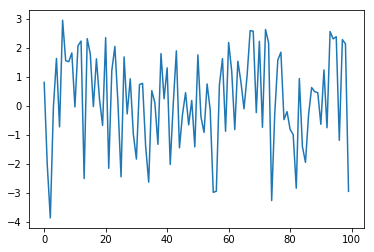

In [432]:
plt.plot(params[1].data.numpy())

In [433]:
pred.mean(dim=0)

Variable containing:
 155.6431
 137.2134
 119.8447
 108.8356
 101.1730
  98.5936
 104.1611
 103.2090
 118.5588
 147.4796
 177.7484
 210.8666
 227.3783
 266.2125
 301.5935
 334.9119
 354.2535
 358.9527
 327.6610
 324.5580
 305.7072
 274.3760
 225.4543
 184.9275
[torch.FloatTensor of size 24]

In [434]:
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)

In [435]:
ORDER

['mw', 'dw', 'dr', 'fridge', 'hvac']

In [446]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(prediction_fold[4], gt_fold[4])

76.563058601759735

In [443]:
pd.DataFrame(prediction_fold[4]).max()

0     3468.868408
1     3550.409180
2     2792.466797
3     2118.350098
4     1875.663818
5     1850.760254
6     2042.962891
7     2483.302734
8     3078.621338
9     2802.892334
10    3163.219238
11    3314.020752
12    3738.854004
13    4858.791504
14    4424.247070
15    4080.482422
16    4714.679688
17    4243.135742
18    5132.514160
19    3571.614258
20    3775.286621
21    4176.157715
22    3283.177002
23    3174.096436
dtype: float32

In [404]:
prediction_fold[0].mean()

893.73639

In [405]:
%matplotlib inline

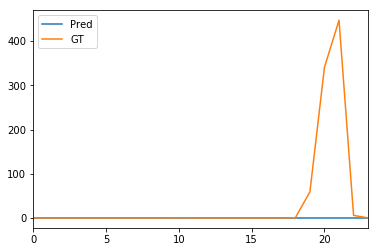

In [422]:
import matplotlib.pyplot as plt
pd.DataFrame(prediction_fold[3]).iloc[4].plot(label='Pred')
pd.DataFrame(gt_fold[3]).iloc[4].plot(label='GT')
plt.legend()

In [1]:



print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})

NameError: name 'cell_type' is not defined